# Building Classification Models

## Machine learning for discovery of MOFs for Carbon Capture

In this projetc, I will build machine learning classification models to identify promising metal–organic frameworks (MOFs) for carbon capture applications.

Carbon capture is a complex challenge involving multiple material considerations — including pore geometry, surface chemistry, mechanical and thermal stability, water stability, and economic feasibility.

To make the problem tractable, I will focus on two experimentally measurable properties that strongly influence performance:
1) CO₂ uptake at low pressure, which reflects adsorption capacity and selectivity.

2) Water stability, which determines a material’s long-term durability and reusability.

By the end of project, I’ll have trained and evaluated models that can distinguish between promising and non-promising MOFs based on these properties — demonstrating how data-driven methods can accelerate materials discovery.

# 0. Setup programming environment

### 0.1 Import packages we will need

In [22]:
# basics
import os
import numpy as np
import pprint as pp

# pandas is used to read/process data
import pandas as pd
from ydata_profiling import ProfileReport

# machine learning dependencies
# scaling of data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# train/test split
from sklearn.model_selection import train_test_split
# model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# the KRR model
from sklearn.kernel_ridge import KernelRidge
# linear model
from sklearn.linear_model import LinearRegression, SGDRegressor
# pipeline to streamline modeling pipelines
from sklearn.pipeline import Pipeline
# principal component analysis
from sklearn.decomposition import PCA
# polynomial kernel
from sklearn.metrics.pairwise import polynomial_kernel
# Dummy model as baseline
from sklearn.dummy import DummyClassifier, DummyRegressor
# Variance Threshold for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
# metrics to measure model performance
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error)
# confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# xg boost classifer
from xgboost import XGBClassifier



# save/load models
import joblib

# For the permutation importance implementation
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import check_scoring
from sklearn.utils import Bunch
from sklearn.utils import check_random_state
from sklearn.utils import check_array

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 0.2 Fix the random seed

In [23]:
# add code here
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

### 0.3 Import the data

I will work with two datasets:

1. I will use the dataset that originating from the publication ["Understanding the diversity of the metal-organic framework     ecosystem"](https://doi.org/10.1038/s41467-020-17755-8) to featurize our MOFs (using geometric descriptors and RACs). This dataset also contains simulated CO2 uptake values, which will be the basis for our target in Task #1

2. My second task will be to predict MOF water stability. Water stability cannot be effectively simulated, and therefore the labels I use are experimental results which have been extracted from literature. They originate from the paper ["MOF-ChemUnity: Unifying metal-organic framework data using large language models"](https://chemrxiv.org/engage/chemrxiv/article-details/6838df8bc1cb1ecda036f363).

In [24]:
# load data locally

DATA_DIR_CO2 = "Data/MOF_CoRE2019.csv"
df_co2 = pd.read_csv(DATA_DIR_CO2)

DATA_DIR_WS = "Data/all_data_ws.csv"
df_ws  = pd.read_csv(DATA_DIR_WS)

print("Loaded both datasets locally.")
print(f"CO₂ shape = {df_co2.shape}, Water stability shape = {df_ws.shape}")


Loaded both datasets locally.
CO₂ shape = (5014, 331), Water stability shape = (1610, 197)


Let's take a look!

In [25]:
df_co2.head()

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-2,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K
0,XAGCUE_clean,0.00,2.87682,6.41175,6.41175,487.410,0.000000,0.0000,0.101882,0.21558,...,10752.0,10752.0,242.0856,523.7232,844.9008,1049.6448,1.266370,3.120211,1.810078,2.173372
1,SOBZEQ_clean,2298.52,5.44324,7.06044,7.04565,0.000,0.738273,0.6363,0.000000,0.00000,...,2240.0,2544.0,58.2840,130.2840,194.2144,231.0000,8.224130,17.486748,4.560643,11.578465
2,AVAQIX01_clean,0.00,3.61603,5.36267,5.34980,600.353,0.000000,0.0000,0.226377,0.30062,...,3040.0,2688.0,91.7328,204.2656,276.2848,265.7760,3.694178,5.849020,3.859973,5.251466
3,INURIS_clean,0.00,3.09799,5.07769,4.57779,253.440,0.000000,0.0000,0.077296,0.09856,...,12720.0,13728.0,301.4544,713.6976,1037.0160,1127.9280,1.007227,4.092395,2.032925,3.728986
4,KEDNOY_clean,0.00,3.63243,4.98967,4.98020,519.714,0.000000,0.0000,0.238159,0.28890,...,2064.0,1920.0,72.0852,153.0144,199.7088,218.5200,3.617103,6.170669,3.924974,4.888655


In [26]:
df_ws.head()

,Di,Df,Dif,V_cell (A^3),density (g/cm^3),ASA (A^2),ASA (m^2/cm^3),ASA (m^2/g),NASA (A^2),NASA (m^2/cm^3),...,D_func-S-0-all,D_func-S-1-all,D_func-S-2-all,D_func-S-3-all,D_func-alpha-0-all,D_func-alpha-1-all,D_func-alpha-2-all,D_func-alpha-3-all,label,ID
0,9.85231,9.71816,9.85231,2819.59,1.08868,258.378,916.368,841.724,0.0000,0.0000,...,0.0,-0.040000,-0.040000,0.300000,0.0,-6.000,-6.000000,-7.307110,1,IBICAZ
1,5.78505,4.38610,5.78505,3064.49,1.02686,332.193,1084.010,1055.650,0.0000,0.0000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0,DAWCOV
2,3.87339,1.02316,3.87339,2315.38,1.66043,0.000,0.000,0.000,13.3378,57.6054,...,0.0,-0.027500,-0.027500,-0.055000,0.0,-3.585,-3.585000,-7.170000,1,YIHBIC
3,4.91962,2.33774,4.87045,3762.23,2.53616,0.000,0.000,0.000,25.5106,67.8072,...,0.0,-0.026667,-0.026667,0.466667,0.0,-4.000,-4.000000,-0.342813,1,ZETPUL
4,2.15464,0.80144,1.41441,1121.03,1.64880,0.000,0.000,0.000,0.0000,0.0000,...,0.0,-0.020000,0.893333,0.000000,0.0,-3.900,7.450077,0.000000,0,KAYBIX


I will now set the water stability dataset aside and only work with the CO2 dataset (I'll come back to it during Task #2).

# Task 1: Identifying MOFs with Promising CO2 Uptakes

## 1.1: Data Cleaning and Prep

### 1.1.1 Basic Cleaning

In [27]:
# Drop duplicate rows
df_co2 = df_co2.drop_duplicates()


# Drop rows with any NaN values
df_co2 = df_co2.dropna()

df_co2.shape

(4999, 331)

### 1.1.2: Splitting our data into classes and loading features/target

First, lets create two classes from data:

1) Promising - a MOF with CO2 Uptake at LP > 2mmol/g
2) Not Promising - a MOF with CO2 Uptake at LP < 2mmol/g

I choose 2mmol/g as  criteria for a "promising" MOF for CO2 capture. This is based on [Mahajan et al. (2022)](https://www.sciencedirect.com/science/article/pii/S2213343722018036), who stated that for a promising candidate for carbon capture, anything greater than 2 mmol CO2/g adsorbent is acceptable.

In [28]:
df_co2['Promise'] = df_co2['CO2 uptake at 0.15 bar and 298K'].apply(lambda x: 'Promising' if x > 2 else 'Not Promising')
df_co2['Promise'].value_counts()

Promise
Not Promising    3206
Promising        1793
Name: count, dtype: int64

In [29]:
df_co2.head()

,MOFname,ASA [m^2/cm^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,...,sum-f-lig-T-3,sum-f-lig-S-0,sum-f-lig-S-1,sum-f-lig-S-2,sum-f-lig-S-3,CO2 uptake at 0.15 bar and 298K,CO2 uptake at 16 bar and 298K,CH4 uptake at 5.8 bar and 298K,CH4 uptake at 65 bar and 298K,Promise
0,XAGCUE_clean,0.00,2.87682,6.41175,6.41175,487.410,0.000000,0.0000,0.101882,0.21558,...,10752.0,242.0856,523.7232,844.9008,1049.6448,1.266370,3.120211,1.810078,2.173372,Not Promising
1,SOBZEQ_clean,2298.52,5.44324,7.06044,7.04565,0.000,0.738273,0.6363,0.000000,0.00000,...,2544.0,58.2840,130.2840,194.2144,231.0000,8.224130,17.486748,4.560643,11.578465,Promising
2,AVAQIX01_clean,0.00,3.61603,5.36267,5.34980,600.353,0.000000,0.0000,0.226377,0.30062,...,2688.0,91.7328,204.2656,276.2848,265.7760,3.694178,5.849020,3.859973,5.251466,Promising
3,INURIS_clean,0.00,3.09799,5.07769,4.57779,253.440,0.000000,0.0000,0.077296,0.09856,...,13728.0,301.4544,713.6976,1037.0160,1127.9280,1.007227,4.092395,2.032925,3.728986,Not Promising
4,KEDNOY_clean,0.00,3.63243,4.98967,4.98020,519.714,0.000000,0.0000,0.238159,0.28890,...,1920.0,72.0852,153.0144,199.7088,218.5200,3.617103,6.170669,3.924974,4.888655,Promising


Note, There is a class imbalance here: about 65% are Not Promising

Let's also define features and targets now as global variables:

In [30]:
# name of descriptors
from MOF_descriptors import geometric_descriptors, linker_descriptors, metalcenter_descriptors, functionalgroup_descriptors, summed_linker_descriptors, summed_metalcenter_descriptors, summed_functionalgroup_descriptors

TARGET = "Promise"
FEATURES = (
    geometric_descriptors
    + summed_functionalgroup_descriptors
    + summed_linker_descriptors
    + summed_metalcenter_descriptors
)

### 1.1.3 Train/Test Split

There is a class imbalance, so I will use a stratified split to seperate the train/test data.

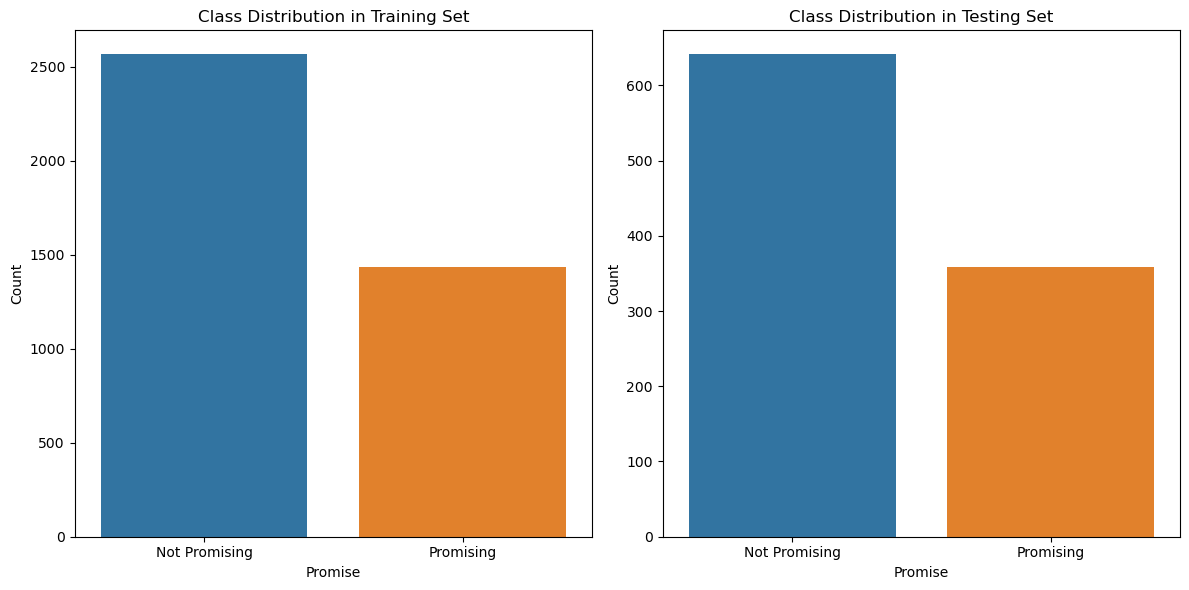

In [31]:
from sklearn.model_selection import train_test_split

X = df_co2[FEATURES]
y = df_co2[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)


# Plot the class distrubition:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Class Distribution in Training Set')
axes[0].set_xlabel('Promise')
axes[0].set_ylabel('Count')

sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title('Class Distribution in Testing Set')
axes[1].set_xlabel('Promise')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

keeping the class distributions the same between training and testing improve model performance:
- Learns from the same proportions of each class it will later see in evaluation
- Avoids being biased toward the majority class during training.

### 1.1.4 Standardize Data
(Always after train-test split, or else its data leakage!)

In [32]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 1.1.5 Make Labels Numeric

In [33]:
# Convert target labels to numerical values (0 or 1)
y_train_numeric = y_train.apply(lambda x: 1 if x == 'Promising' else 0)
y_test_numeric = y_test.apply(lambda x: 1 if x == 'Promising' else 0)

## 1.2: EDA and Feature Selection

### 1.2.1: Remove Redundant Columns

In [34]:
# Initialize VarianceThreshold with a threshold of 0
selector = VarianceThreshold(threshold=0)

# Fit on the training data and transform both training and testing data
X_train_reduced = selector.fit_transform(X_train)
X_test_reduced = selector.transform(X_test)

# Get the names of the selected features
selected_features = X_train.columns[selector.get_support()]

# Update the feature list and DataFrames
FEATURES = selected_features.tolist()
X_train = pd.DataFrame(X_train_reduced, columns=FEATURES, index=X_train.index)
X_test = pd.DataFrame(X_test_reduced, columns=FEATURES, index=X_test.index)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features after removing zero variance features: {X_train.shape[1]}")
print("\nUpdated feature list:")
print(FEATURES)

Original number of features: 164
Number of features after removing zero variance features: 138

Updated feature list:
['Di', 'Df', 'Dif', 'density [g/cm^3]', 'total_SA_volumetric', 'total_SA_gravimetric', 'total_POV_volumetric', 'total_POV_gravimetric', 'sum-func-chi-0-all', 'sum-func-chi-1-all', 'sum-func-chi-2-all', 'sum-func-chi-3-all', 'sum-func-Z-0-all', 'sum-func-Z-1-all', 'sum-func-Z-2-all', 'sum-func-Z-3-all', 'sum-func-I-0-all', 'sum-func-I-1-all', 'sum-func-I-2-all', 'sum-func-I-3-all', 'sum-func-T-0-all', 'sum-func-T-1-all', 'sum-func-T-2-all', 'sum-func-T-3-all', 'sum-func-S-0-all', 'sum-func-S-1-all', 'sum-func-S-2-all', 'sum-func-S-3-all', 'sum-func-alpha-0-all', 'sum-func-alpha-1-all', 'sum-func-alpha-2-all', 'sum-func-alpha-3-all', 'sum-D_func-chi-1-all', 'sum-D_func-chi-2-all', 'sum-D_func-chi-3-all', 'sum-D_func-Z-1-all', 'sum-D_func-Z-2-all', 'sum-D_func-Z-3-all', 'sum-D_func-T-1-all', 'sum-D_func-T-2-all', 'sum-D_func-T-3-all', 'sum-D_func-S-1-all', 'sum-D_func-S-2-

### 1.2.2: Remove Highly Correlated Features

In [35]:
# Calculate the correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

print(f"Original number of features: {len(FEATURES)}")
print(f"Number of features after removing highly correlated features: {X_train.shape[1]}")
print("\nDropped features:")
print(to_drop)

# Update the global FEATURES list
FEATURES = X_train.columns.tolist()

Original number of features: 138
Number of features after removing highly correlated features: 49

Dropped features:
['Dif', 'total_POV_volumetric', 'sum-func-Z-2-all', 'sum-func-Z-3-all', 'sum-func-I-0-all', 'sum-func-I-1-all', 'sum-func-I-2-all', 'sum-func-I-3-all', 'sum-func-T-0-all', 'sum-func-T-1-all', 'sum-func-T-2-all', 'sum-func-T-3-all', 'sum-func-S-0-all', 'sum-func-S-1-all', 'sum-func-S-2-all', 'sum-func-S-3-all', 'sum-func-alpha-1-all', 'sum-D_func-Z-1-all', 'sum-D_func-Z-3-all', 'sum-D_func-S-1-all', 'sum-D_func-S-2-all', 'sum-D_func-S-3-all', 'sum-D_func-alpha-1-all', 'sum-f-lig-chi-1', 'sum-f-lig-chi-2', 'sum-f-lig-chi-3', 'sum-f-lig-Z-0', 'sum-f-lig-Z-1', 'sum-f-lig-Z-2', 'sum-f-lig-Z-3', 'sum-f-lig-I-0', 'sum-f-lig-I-1', 'sum-f-lig-I-2', 'sum-f-lig-I-3', 'sum-f-lig-T-0', 'sum-f-lig-T-1', 'sum-f-lig-T-2', 'sum-f-lig-T-3', 'sum-f-lig-S-0', 'sum-f-lig-S-1', 'sum-f-lig-S-2', 'sum-f-lig-S-3', 'sum-lc-Z-1-all', 'sum-lc-Z-2-all', 'sum-lc-Z-3-all', 'sum-lc-I-0-all', 'sum-lc-I-

- Highly correlated features are redundant. They provide overlapping information, and only one of these overlapping features is needed to give the model this signal. Redundant features can make the model less stable, inflate coefficient magnitudes (especially in linear models), and reduce interpretability without improving performance.
- I also care about feature–target correlation for predictive power. But, an important step in feature engineering is checking feature–feature correlation, which ensures the model learns independent, non-redundant signals.
- Feature–target correlation makes less sense for classification, since the target is categorical — the correlation only captures mean differences between classes, not the true strength or shape of the relationship.

## 1.3 Classification Metrics

Let's write the function `get_classification_metrics(model, X, y_true)` that compute the metrics and return this dictionary for a given model. Include these metrics in your function:

$$
\mathrm{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} \\
\mathrm{Precision} = \frac{TP}{TP + FP} \\
\mathrm{Recall} = \frac{TP}{TP + FN} \\
\mathrm{F1\text{-}Score} = 2 \times \frac{\mathrm{Precision} \times \mathrm{Recall}}{\mathrm{Precision} + \mathrm{Recall}}
$$


In [36]:
def get_classification_metrics(model, X, y_true):
    """
    Get a dictionary with basic classification metrics:

    model: sklearn-like model with predict method
    X: feature matrix
    y_true: ground truth binary labels ('Promising' or 'Not Promising')
    """
    # Get model predictions
    # Convert predictions to the same format as y_true
    y_pred_numeric = model.predict(X)
    y_pred = pd.Series(y_pred_numeric).apply(lambda x: 'Promising' if x > 0.5 else 'Not Promising')
    y_pred.index = y_true.index # Ensure indices align

    # Compute confusion matrix components using element-wise comparison
    TP = ((y_true == 'Promising') & (y_pred == 'Promising')).sum()
    FP = ((y_true == 'Not Promising') & (y_pred == 'Promising')).sum()
    FN = ((y_true == 'Promising') & (y_pred == 'Not Promising')).sum()
    TN = ((y_true == 'Not Promising') & (y_pred == 'Not Promising')).sum()


    # Compute metrics manually
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    return metrics_dict

- Accuracy measures overall correctness.
- Precision measures how reliable the positive predictions are
- Recall measures how many actual positives were captured.
- F1-score balances precision and recall — especially useful when the classes are imbalanced.

## 1.4: Logistic Regression

Classification isn’t fundamentally different from regression — it’s just regression with a different output interpretation and loss function. To demonstrate, I will fill in the sigmoid func
tion and the log-loss function for this custom logistic regression class.

### 1.4.1: Logistic Regression From Scratch

### The sigmoid converts any real value into a probability between 0 and 1:
$$
\sigma(z) = \frac{1}{1 + e^{-z}} \\
$$

It maps large negative values → 0, large positive values → 1.



### The log-loss (binary cross-entropy) measures how close predicted probabilities are to the true labels:
$$
\mathrm{Binary\ Cross\text{-}Entropy\ Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$
It heavily penalizes confident wrong predictions


In [37]:
import numpy as np

class MyLogisticRegression:
    def __init__(self, lr=1e-1, n_iters=2000, tol=1e-8, random_state=0):
        """
        Simple Logistic Regression trained using Gradient Descent on Log-Loss.

        Parameters
        ----------
        lr : float
            Learning rate for gradient descent.
        n_iters : int
            Maximum number of iterations for gradient descent.
        tol : float
            Stopping criterion based on loss improvement.
        random_state : int
            Seed for reproducibility.
        """
        self.lr = lr
        self.n_iters = n_iters
        self.tol = tol
        self.random_state = random_state

        self.coef_ = None
        self.intercept_ = 0.0

    # ----------------------------------------------------------------------
    # STEP 1: Sigmoid function
    # ----------------------------------------------------------------------
    @staticmethod
    def _sigmoid(z):
        """
        TODO (students): Implement the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))
        raise NotImplementedError("_sigmoid not implemented yet.")

    # ----------------------------------------------------------------------
    # STEP 2: Log-loss function
    # ----------------------------------------------------------------------
    @staticmethod
    def _log_loss(p, y):
        """
        TODO (students): Implement the binary cross-entropy loss.
        L = - mean( y*log(p) + (1-y)*log(1-p) )
        """
        eps = 1e-12
        p = np.clip(p, eps, 1 - eps)  # avoid log(0)
        L = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
        return L
        raise NotImplementedError("_log_loss not implemented yet.")

    # ----------------------------------------------------------------------
    # STEP 3: Training (Gradient Descent)
    # ----------------------------------------------------------------------
    def fit(self, X, y):
        """
        Fit the logistic regression model on (X, y) using gradient descent.
        """
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1,)

        # Add bias (intercept) column
        Xp = np.c_[np.ones((X.shape[0], 1)), X]

        # GRADIENT DESCENT
        n_features = Xp.shape[1]
        theta = rng.normal(scale=0.01, size=n_features)
        prev_loss = np.inf
        for i in range(self.n_iters):
            # --- Forward pass ---
            z = Xp @ theta
            p = self._sigmoid(z)

            # --- Compute residuals and loss ---
            residuals = p - y
            loss = self._log_loss(p, y)

            # --- Convergence check ---
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

            # --- Compute gradient ---
            grad = (Xp.T @ residuals) / len(y)
            theta -= self.lr * grad

        # Unpack learned parameters
        self.intercept_ = float(theta[0])
        self.coef_ = theta[1:]
        return self


    # ----------------------------------------------------------------------
    # STEP 4: Predictions
    # ----------------------------------------------------------------------
    def predict_proba(self, X):
        """
        Return predicted probabilities for class 0 and class 1.
        """
        X = np.asarray(X, dtype=float)
        X = np.c_[np.ones((X.shape[0], 1)), X]  # always include bias column
        z = X @ np.r_[self.intercept_, self.coef_]
        p1 = self._sigmoid(z)
        return np.c_[1 - p1, p1]

    def predict(self, X, threshold=0.5):
        """
        Predict binary class labels (0 or 1).
        """
        return (self.predict_proba(X)[:, 1] >= threshold).astype(int)

Unlike linear regression, logistic regression has no closed form solution! Logistic regression’s loss involves a sigmoid, making it nonlinear — so I  must use iterative methods like gradient descent.


Now, train linear regressor on the classification task

In [38]:
# Instantiate and train the MyLogisticRegression model
logistic_reg_model = MyLogisticRegression(lr=1e-1, n_iters=2000, random_state=RANDOM_SEED)
logistic_reg_model.fit(X_train_scaled, y_train_numeric)

# Evaluate the model using the classification metrics function
# The get_classification_metrics function expects the model, X (scaled features), and y_true (string labels)
metrics = get_classification_metrics(logistic_reg_model, X_test_scaled, y_test)

print("Classification Metrics for MyLogisticRegression (from scratch):")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Classification Metrics for MyLogisticRegression (from scratch):
accuracy: 0.7170
precision: 0.6387
recall: 0.4875
f1: 0.5529


Generate a confusion matric using sklearn

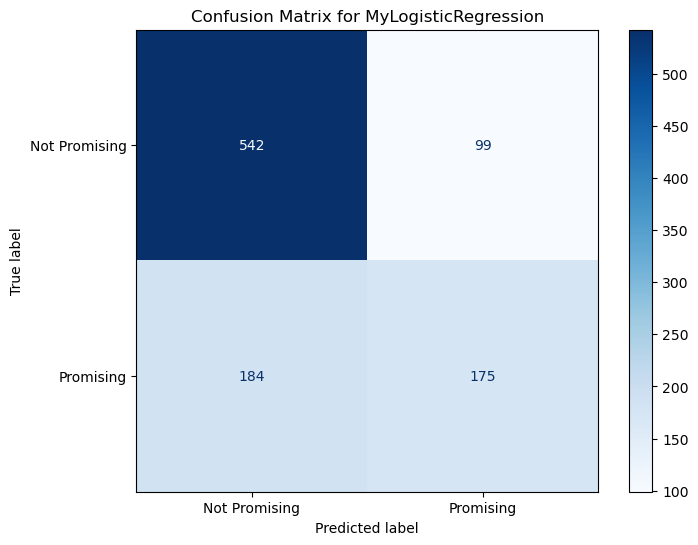

In [39]:
# Get predictions
y_pred_numeric = logistic_reg_model.predict(X_test_scaled)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_numeric, y_pred_numeric)

# Get the class labels
class_labels = ['Not Promising', 'Promising']

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for MyLogisticRegression')
plt.show()

- I want to minimize the number of promising MOFs that are predicted to be not promising! (Bottom left corner of confusion matrix, false negatives).
- I could lower the decision boundary to predict “positive” more often → fewer false negatives (at the cost of more false positives). This could reduce overall model performance, but w.r.t. what's important, it makes sense

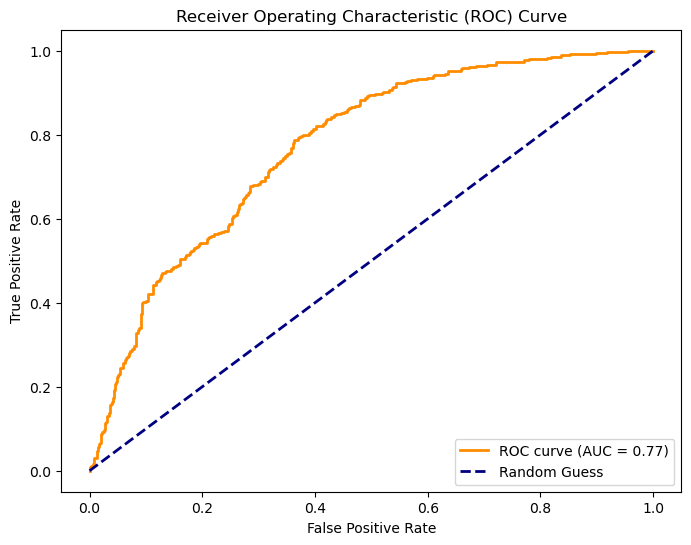

AUC: 0.7724


In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class ('Promising' which is 1)
# The predict_proba method of MyLogisticRegression returns probabilities for class 0 and 1
y_pred_proba = logistic_reg_model.predict_proba(X_test_scaled)[:, 1]

# The roc_curve function expects binary true labels (0 or 1)
y_test_numeric = y_test.apply(lambda x: 1 if x == 'Promising' else 0)

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc:.4f}")

# Task 2: Identifying Water Stable MOFs

Now that I've built a model for predicting MOFs with promising CO2 uptakes, let's move on to predicting MOF water stability! Water stability more difficult to predict, and I also have less data points, so I will use a more complicated classification model - XGBoost.

## 2.1: Data Prep and Splitting

Note: I will not be doing feature selection on this dataset. However, I will remove two features known as redundant:

density_2 (g/cm^3) - This is a duplicate feature.

V_cell_2 (A^3) - Cell volume depends on how the unit cell is defined, not the material itself. It is not a feature with meaningful signal.


### 2.1.1: Set features and targets

In [41]:
# Define the target for water stability
TARGET_WS = 'label' # Assuming 'label' column contains the water stability labels (0 or 1)

# Define features for water stability (all columns except target and ID)
# Get all columns from df_ws
all_ws_cols = df_ws.columns.tolist()

# Remove the target and ID columns from the feature list
FEATURES_WS = [col for col in all_ws_cols if col not in [TARGET_WS, 'ID']]

# --- Remove some specific features ---
features_to_drop = ['V_cell_2 (A^3)', 'density_2 (g/cm^3)']
FEATURES_WS = [col for col in FEATURES_WS if col not in features_to_drop]

# Create the feature matrix (X_ws) and target vector (y_ws)
X_ws = df_ws[FEATURES_WS]
y_ws = df_ws[TARGET_WS]

print(f"Shape of features (X_ws) for water stability task: {X_ws.shape}")
print(f"Shape of target (y_ws) for water stability task: {y_ws.shape}")

# Display the distribution of the new target variable
print("\nWater Stability Class Distribution:")
print(y_ws.value_counts())

Shape of features (X_ws) for water stability task: (1610, 193)
Shape of target (y_ws) for water stability task: (1610,)

Water Stability Class Distribution:
label
1    1076
0     534
Name: count, dtype: int64


There is a pretty large class imbalance for this dataset!

### 2.2.2: Split data into train and test

In [42]:
# Stratified train-test split for water stability data
X_ws_train, X_ws_test, y_ws_train, y_ws_test = train_test_split(
    X_ws, y_ws, test_size=0.2, random_state=1, stratify=y_ws
)

## 2.2: Baseline Model

Here, I will use a dummy model as a baseline:

What will the accuracy of our dummy model be with this dataset split?
- In the confusion matrix, the model predicts “Stable” much more often (245 vs 77)
- Since the class split is ~2:1 in favour of the positive class, a dummy model that predicts "Stable" for everything would score an accuracy of 0.67. The model is not much better.



Classification Metrics for Dummy Baseline Model:
Accuracy: 0.6677
Precision: 0.6677
Recall: 1.0000
F1-Score: 0.8007


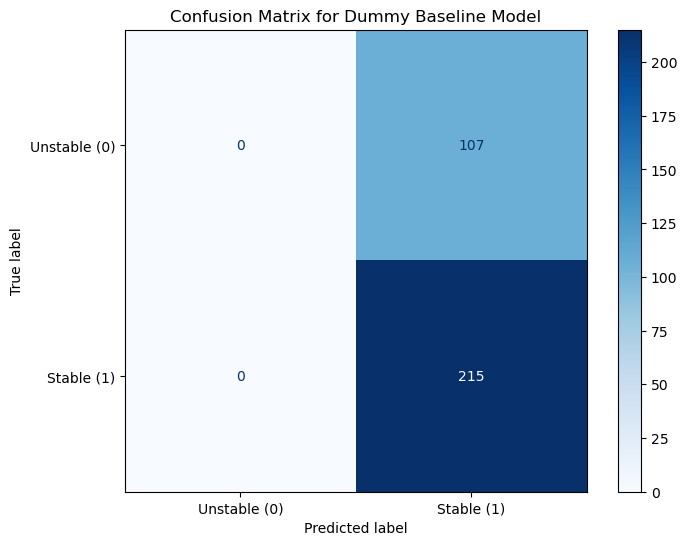

In [43]:
# Instantiate DummyClassifier (strategy='most_frequent' is a common baseline for imbalanced data)
dummy_model = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)

# Train the dummy model on the training data
dummy_model.fit(X_ws_train, y_ws_train)

# Make predictions on the test set
y_ws_pred_dummy = dummy_model.predict(X_ws_test)

# Evaluate using sklearn's metrics
accuracy_dummy = accuracy_score(y_ws_test, y_ws_pred_dummy)
precision_dummy = precision_score(y_ws_test, y_ws_pred_dummy, zero_division=0) # Add zero_division=0 to handle cases with no positive predictions
recall_dummy = recall_score(y_ws_test, y_ws_pred_dummy, zero_division=0)
f1_dummy = f1_score(y_ws_test, y_ws_pred_dummy, zero_division=0)


print("\nClassification Metrics for Dummy Baseline Model:")
print(f"Accuracy: {accuracy_dummy:.4f}")
print(f"Precision: {precision_dummy:.4f}")
print(f"Recall: {recall_dummy:.4f}")
print(f"F1-Score: {f1_dummy:.4f}")

# Display Confusion Matrix
cm_dummy = confusion_matrix(y_ws_test, y_ws_pred_dummy)

class_labels_ws = ['Unstable (0)', 'Stable (1)'] # Define if not found


disp_dummy = ConfusionMatrixDisplay(confusion_matrix=cm_dummy, display_labels=class_labels_ws)

fig_dummy, ax_dummy = plt.subplots(figsize=(8, 6))
disp_dummy.plot(cmap=plt.cm.Blues, ax=ax_dummy)
plt.title('Confusion Matrix for Dummy Baseline Model')
plt.show()

## 2.3 Set up Pipeline

Create a pipeline that scales your features and uses XGBoost classifer with default parameters.

In [44]:
# Define the pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Train the XGBoost model using the pipeline on the training data
# Using X_ws_train and y_ws_train which contain all original features for WS task before manual feature selection steps
pipeline.fit(X_ws_train, y_ws_train)


c:\Users\mrast\.conda\envs\che1147\lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:37] WARNING: D:\bld\xgboost-split_1758007517675\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('scaler', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


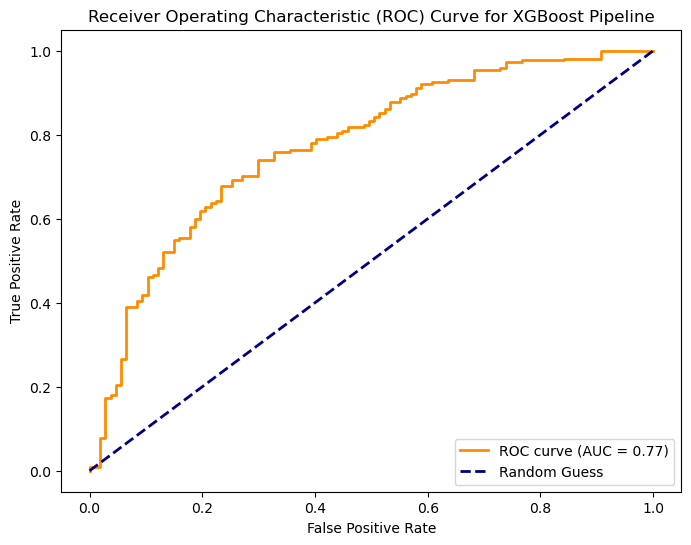

AUC for XGBoost Pipeline: 0.7749


In [45]:
# Get the predicted probabilities for the positive class (class 1) from the pipeline
y_ws_pred_proba_pipeline = pipeline.predict_proba(X_ws_test)[:, 1]

# Calculate ROC curve points
fpr_pipeline, tpr_pipeline, thresholds_pipeline = roc_curve(y_ws_test, y_ws_pred_proba_pipeline)

# Calculate AUC
roc_auc_pipeline = auc(fpr_pipeline, tpr_pipeline)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_pipeline, tpr_pipeline, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_pipeline:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Pipeline')
plt.legend(loc='lower right')
plt.show()

print(f"AUC for XGBoost Pipeline: {roc_auc_pipeline:.4f}")